Baseline Modelling

In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from scipy.stats import pearsonr
from statsmodels.api import tsa
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#reading csv with columns because of the index column
df = pd.read_csv("../data/FinalData.csv",usecols=['date', 'open', 'high', 'low', 'close', 'Volume BTC','Volume USD'])
#converting date column to date time
df['date'] = pd.to_datetime(df['date'])
#setting date as index for easier timer series analysis
df.set_index('date', inplace=True)

In [4]:
# Simple Moving Averages (SMA)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (EMA)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

In [5]:
#dropping NA values because of moving average creation
df.dropna(inplace=True)

In [6]:
# Defining target variable and features
target = 'high'
features = ['open', 'close', 'low', 'Volume BTC', 'Volume USD', 'SMA_20', 'SMA_50']

In [7]:
X = df[features]
y = df[target]

In [8]:
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [9]:
#splitting the data based on date for ARIMAX modelling
train_end_date = '2023-03-06'
ARIMA_target = df[target]
y_train = ARIMA_target[ARIMA_target.index < train_end_date]
y_test = ARIMA_target[ARIMA_target.index >= train_end_date]
X_train = df[features][df.index < train_end_date]
X_test = df[features][df.index >= train_end_date]


Building some baseline models and evaluating them

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [11]:
m2_lr = mean_squared_error(y_test, y_pred_lr)
ma_lr =  mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [12]:
print(f'For our linear regression model the R squared value is {r2_lr}')
print(f'For our linear regression model the mean squared error is {m2_lr}')
print(f'For our linear regression model the mean absolute error is {ma_lr}')

For our linear regression model the R squared value is 0.9999454323267373
For our linear regression model the mean squared error is 12619.29193777318
For our linear regression model the mean absolute error is 77.82679739963596


In [13]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [14]:
print(f"DT R^2 score on training set: {dt_model.score(X_train, y_train):0.3f}")
print(f"DT R^2 score on test set: {dt_model.score(X_test, y_test):0.3f}")
print(f'For our decision tree model the mean squared error is {mean_squared_error(y_test, y_pred_dt)}')
print(f'For our decision tree model the mean absolute error is {mean_absolute_error(y_test, y_pred_dt)}')

DT R^2 score on training set: 1.000
DT R^2 score on test set: 0.998
For our decision tree model the mean squared error is 348999.09898626275
For our decision tree model the mean absolute error is 234.90545404259225


Lets Build an ARIMAX model too

In [15]:
data = df.sort_index()

# Setting the frequency of the date index
data = df.asfreq(pd.infer_freq(df.index))

In [16]:
p_param = 1
d_param = 1
q_param = 1

model = SARIMAX(y_train, order=(p_param, d_param, q_param), exog= X_train)
model_fit = model.fit(disp=0)

model_fit.summary()

e:\Anaconda\envs\plotly_bokeh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Anaconda\envs\plotly_bokeh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Anaconda\envs\plotly_bokeh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Anaconda\envs\plotly_bokeh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Anaconda\en

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   high   No. Observations:                64927
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -372414.973
Date:                Thu, 04 Jul 2024   AIC                         744849.945
Time:                        20:05:35   BIC                         744940.755
Sample:                             0   HQIC                        744878.050
                              - 64927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open           0.5051      0.001    826.981      0.000       0.504       0.506
close          0.5311      0.001    787.910      0.000       0.530       0.532
low           -0.0459      0.001    -56.765      0.000      -0.048      -0.044
Volume BTC    -0.0279      0.001    -19.388      0.000      -0.031      -0.025
Volume USD  1.651e-05   5.83e-08    283.355      0.000    1.64e-05    1.66e-05
SMA_20         0.0252      0.001     17.183      0.000       0.022       0.028
SMA_50        -0.0050      0.002     -2.023      0.043      -0.010      -0.000
ar.L1          0.0490      0.002     22.355      0.000       0.045       0.053
ma.L1         -0.7381      0.002   -387.308      0.000      -0.742      -0.734
sigma2      6023.3215   8.51e-08   7.08e+10      0.000    6023.322    6023.322
===================================================================================
Ljung-Box (L1) (Q):                 669.26   Jarque-Bera (JB):           6308961.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             2.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+25. Standard errors may be unstable.
"""

In [17]:
forecast = model_fit.forecast(steps=len(y_test), exog = X_test)

e:\Anaconda\envs\plotly_bokeh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\Anaconda\envs\plotly_bokeh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [18]:

mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)

In [19]:
print('MAE:', mae)
print('MSE:', mse)

MAE: 309.8524253625254
MSE: 114951.0449691441


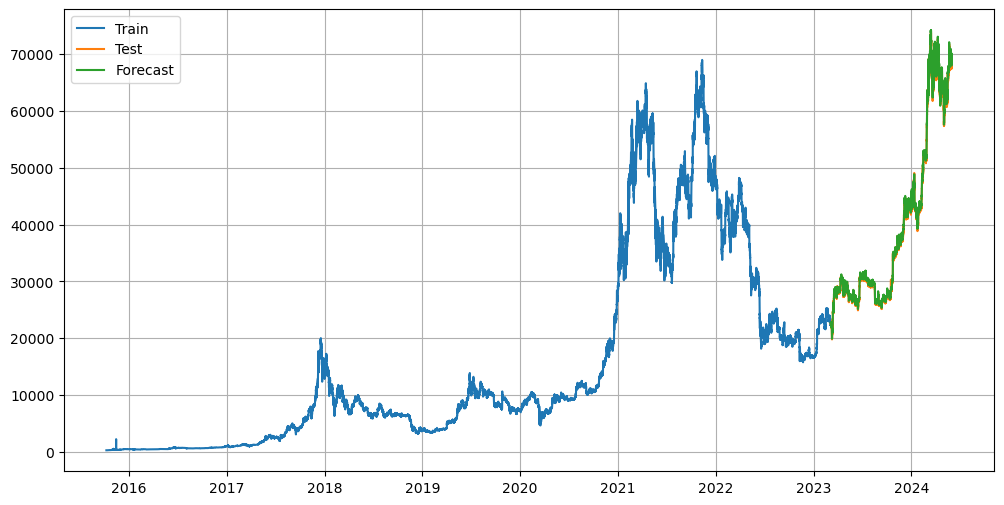

In [20]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast')
plt.legend()
plt.grid()
plt.show()

Finding the best parameters using grid search

In [21]:
estimators = [('dim_reducer', PCA()),
              ('model', DecisionTreeRegressor())]
pipe = Pipeline(estimators)

In [22]:
param_grid = [
    {
        'dim_reducer': [PCA(), None],
        'model': [DecisionTreeRegressor()],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'dim_reducer': [PCA(), None],
        'model': [RandomForestRegressor()],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'dim_reducer': [PCA(), None],
        'model': [GradientBoostingRegressor()],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.05],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
]

In [23]:
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=7, verbose= 2)
fitted_grid = grid.fit(X_train, y_train)


Fitting 5 folds for each of 1746 candidates, totalling 8730 fits


In [24]:
best_model = fitted_grid.best_estimator_
best_params = fitted_grid.best_params_

In [25]:
print("Best Parameters:", best_params)
print("Best Model:", best_model)

Best Parameters: {'dim_reducer': None, 'model': DecisionTreeRegressor(max_depth=20, min_samples_leaf=4), 'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Best Model: Pipeline(steps=[('dim_reducer', None),
                ('model',
                 DecisionTreeRegressor(max_depth=20, min_samples_leaf=4))])


In [29]:
y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

In [30]:
print(f'Mean Squared Error: {mse_tuned}')
print(f'Mean Absolute Error: {mae_tuned}')
print(f'R^2 Score: {r2_tuned}')

Mean Squared Error: 330159.241193731
Mean Absolute Error: 223.75925503869883
R^2 Score: 0.9985723429106044


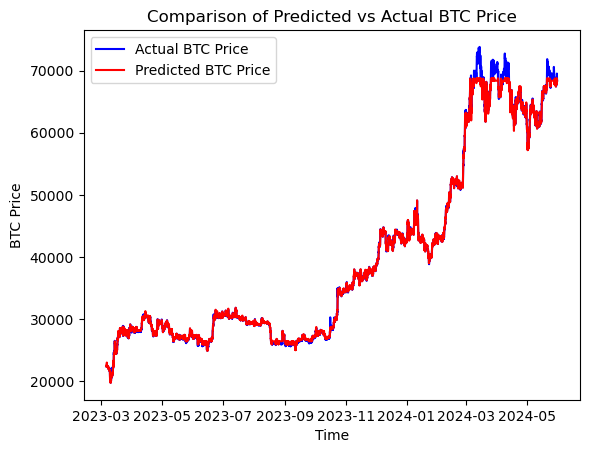

In [32]:
plt.plot(y_test.index, y_test, label='Actual BTC Price', color='blue')
plt.plot(y_test.index, y_pred_tuned, label='Predicted BTC Price', color='red')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.title('Comparison of Predicted vs Actual BTC Price')
plt.legend()
plt.show()

In [33]:
#saving the best model for later use
import joblib
joblib.dump(best_model, '../model/best_btc_model.pkl')

['../model/best_btc_model.pkl']